In [130]:
import asyncio
from websockets.asyncio.client import connect as wsconnect
import logging
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from scipy import stats
import nest_asyncio

nest_asyncio.apply()

URL = "wss://fstream.binance.com/ws"
SYMBOL = "btcusdt@bookTicker"
CONNS = 5
TIMEOUT_S = 60

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)


raw_conns_data = [[] for _ in range(CONNS)]

In [131]:
async def collect_conn_data(conn_id: int):
    """Opens ws connection by id and collects data"""
    async with wsconnect(URL) as ws:
        await ws.send(json.dumps({"method": "SUBSCRIBE", "params": [SYMBOL], "id": conn_id}))
        logger.info(f"Connection {conn_id} subbed")

        try:
            while True:
                message = await ws.recv()
                now_ms = datetime.now(timezone.utc).timestamp() * 1000
                data = json.loads(message)

                if "E" in data and "u" in data:
                    latency = now_ms - data["E"]
                    update_id = data["u"]

                    raw_conns_data[conn_id].append({
                        "ts": now_ms,
                        "upd_id": update_id,
                        "lat": latency,
                        "conn_id": conn_id
                    })
        except asyncio.CancelledError:
            logger.info(f"Connection {conn_id} cancelled")
        except Exception as e:
            logger.error(f"Connection {conn_id} error: {e}")


async def run_collect(timeout_s: int) -> list[pd.DataFrame]:
    """Collects data for all connections for set duration"""
    tg = asyncio.gather(*[collect_conn_data(conn_id) for conn_id in range(CONNS)])
    try:
        await asyncio.sleep(timeout_s)
    finally:
        tg.cancel()

    return [pd.DataFrame(data) for data in raw_conns_data]

In [132]:
conns_data = await run_collect(TIMEOUT_S)

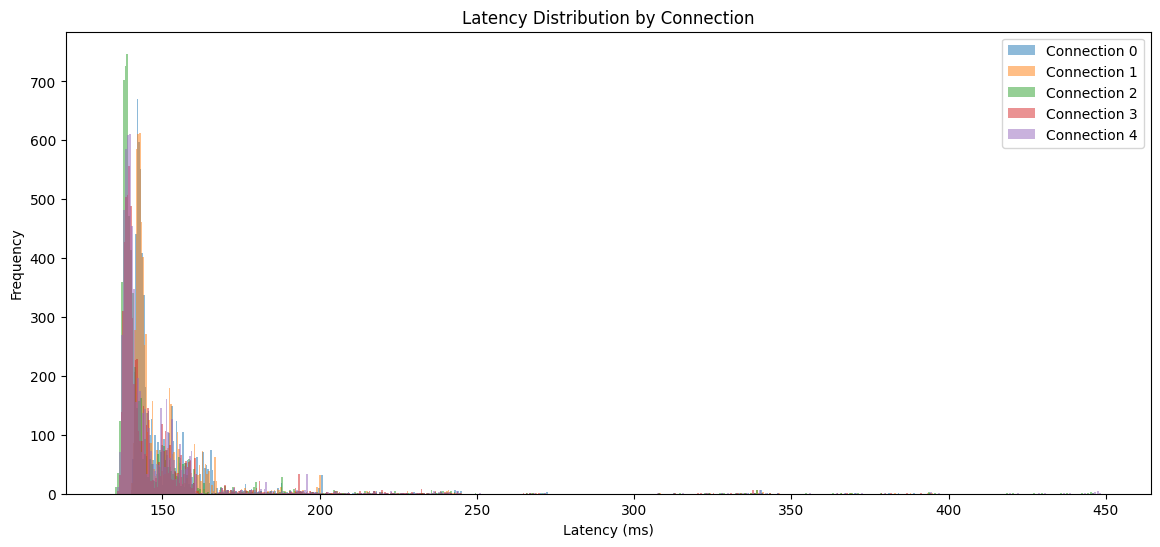

In [133]:
plt.figure(figsize=(14, 6))
for i, data in enumerate(conns_data):
    if not data.empty:
        latencies = data["lat"]
        plt.hist(latencies, bins=512, alpha=0.5, label=f"Connection {i}")

plt.title("Latency Distribution by Connection")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [134]:
from collections import defaultdict

all_data = pd.concat(conns_data)
grouped_data = all_data.groupby('upd_id')

fast_upd = defaultdict(int)
for _, group in grouped_data:
    min_ts = group["ts"].min() 
    first_conns = group[group["ts"] == min_ts]["conn_id"]

    fast_upd[first_conns.iloc[0]] += 1

total_upd = len(conns_data[0])
fast_upd_ratio = { conn: count / total_upd for conn, count in fast_upd.items() }
print("Fast Update Ratios:")
for conn, ratio in fast_upd_ratio.items():
    print(f"Connection {conn}: {ratio:.2%}")

Fast Update Ratios:
Connection 1: 0.17%
Connection 3: 8.59%
Connection 2: 84.30%
Connection 4: 6.71%
Connection 0: 0.28%


Half of connections approximately has one mean latency and other half has another mean but displaced from the first half.   

I would assume that the servers for websockets may have slightly different load between each other or have 
heterogeneous hardware resources or distributed into several datacenters with diff rtt to them. Each of our connections probably should go through a load balancer. Load balancing algorighms are not strictly perfect when distributing the load, even the dynamic ones.   

So, one part of created ws connected to one group of servers and others to a differnet one. That's the reason why connections stats are seemed to be grouped and very close to each other within the same group.

In [135]:
latencies_by_conns = [ df["lat"].dropna() for df in conns_data if not df.empty ]
p_values = []
for i in range(CONNS):
    for j in range(i + 1, CONNS):
        _, p_mean = stats.ttest_ind(latencies_by_conns[i], latencies_by_conns[j], equal_var=True)
        _, p_std = stats.levene(latencies_by_conns[i], latencies_by_conns[j])

        p_values.append((f"Conn {i} vs Conn {j}", p_mean, p_std))

print("Latency Stat Tests (Mean and Std):")
for label, p_mean, p_std in p_values:
    print(f"{label} - p_mean: {p_mean:.4f}, p_std: {p_std:.4f}")


latencies_by_conns = [latencies[latencies > 175] for latencies in latencies_by_conns]
p_values = []
for i in range(CONNS):
    for j in range(i + 1, CONNS):
        _, p_mean = stats.ttest_ind(latencies_by_conns[i], latencies_by_conns[j], equal_var=True)
        _, p_std = stats.levene(latencies_by_conns[i], latencies_by_conns[j])

        p_values.append((f"Conn {i} vs Conn {j}", p_mean, p_std))

print("\nFiltered Latency Stat Tests (Mean and Std):")
for label, p_mean, p_std in p_values:
    print(f"{label} - p_mean: {p_mean:.4f}, p_std: {p_std:.4f}")

Latency Stat Tests (Mean and Std):
Conn 0 vs Conn 1 - p_mean: 0.7777, p_std: 0.8490
Conn 0 vs Conn 2 - p_mean: 0.0000, p_std: 0.9796
Conn 0 vs Conn 3 - p_mean: 0.0000, p_std: 0.1220
Conn 0 vs Conn 4 - p_mean: 0.0000, p_std: 0.0441
Conn 1 vs Conn 2 - p_mean: 0.0000, p_std: 0.8493
Conn 1 vs Conn 3 - p_mean: 0.0000, p_std: 0.0863
Conn 1 vs Conn 4 - p_mean: 0.0000, p_std: 0.0671
Conn 2 vs Conn 3 - p_mean: 0.8241, p_std: 0.1910
Conn 2 vs Conn 4 - p_mean: 0.0008, p_std: 0.0680
Conn 3 vs Conn 4 - p_mean: 0.0004, p_std: 0.0009

Filtered Latency Stat Tests (Mean and Std):
Conn 0 vs Conn 1 - p_mean: 0.7342, p_std: 0.6998
Conn 0 vs Conn 2 - p_mean: 0.0044, p_std: 0.0002
Conn 0 vs Conn 3 - p_mean: 0.9070, p_std: 0.6598
Conn 0 vs Conn 4 - p_mean: 0.0018, p_std: 0.0004
Conn 1 vs Conn 2 - p_mean: 0.0115, p_std: 0.0008
Conn 1 vs Conn 3 - p_mean: 0.6595, p_std: 0.9564
Conn 1 vs Conn 4 - p_mean: 0.0051, p_std: 0.0016
Conn 2 vs Conn 3 - p_mean: 0.0047, p_std: 0.0012
Conn 2 vs Conn 4 - p_mean: 0.8038, p_s